# **Testing of multivariate extension to nonstationary model fitting**

- aim: make all methods compatible with 0, 1 or n>1 covariates

In [1]:
# all functions are taken from original model fitting script unless superseded below
source("../../wwa_model-fitting.R")

---
# **Modified functions**

## **Parameter estimation**

### `ns_loglik`

_Needs rewriting so that nonstationary location & scale all come from the `ns_pars` method_

In [2]:
ns_loglik <- function(pars, cov, x, dist, fittype) {

    effect <- rowSums(sapply(names(cov), function(cnm) pars[paste0("alpha_",cnm)] * cov[,cnm]))
    
    # compute nonstationary location & scale
    if(fittype == "fixeddisp") {
        const = exp(effect / pars["mu0"])
        loc = pars["mu0"] * const
        scale = pars["sigma0"] * const
    } else if(fittype == "shift") {
        loc = pars["mu0"] + effect
        scale = pars["sigma0"]
    } else {
        print(paste(fittype, "not implemented"))
        return()
    }

    # constrain variance to be strictly positive
    if(any(scale <= 0)) return(NA)
        
    # return negative log-likelihood
    if(dist == "norm") {
        return(-sum(dnorm(x, mean = loc, sd = scale, log = T)))
    } else if(dist == "gev") {
        shape = pars["shape"]
        return(-sum(devd(x, loc = loc, scale = scale, shape = shape, log = T)))
    } else {
        print(paste(dist, "not implemented"))
        return()
    }
}

### `fit_ns`

In [3]:
fit_ns <- function(dist, type = "fixeddisp", data, varnm, covnm, lower = F, mintemps = F, ev = NA, method = "BFGS", ...) {
    
    # currently only works for distributions fully specified by mean & sd: only tested for normal, lognormal
    if(! dist %in% c("norm", "gev")) {
        print("Not yet implemented: use norm or gev")
        return()
    }
    
    # add something here to automatically handle no covariates
    
    # if looking at minimum temperatures (or minima of negative values generally), need to flip data for stable model fitting
    x <- data[,varnm]; if(mintemps) x <- -x
    cov <- data[, covnm, drop = F]
    k <- length(covnm)
    
    # fit model with appropriate number of parameters, pad if necessary
    init <- c("mu0" = mean(x), "sigma0" = sd(x), setNames(rep(0,k), paste0("alpha_", covnm)))

    if(dist == "gev") init <- c(init, "shape" = 0)
    fitted <- suppressWarnings(optim(par = init, ns_loglik, cov = cov, x = x, dist = dist, fittype = type, method = method))
    
    # if looking at minimum temperatures (or minima of negative values generally), so trend & location parameters have been flipped. This may cause some confusion so may have to modify later!
    if(mintemps) {
        fitted[["NOTE"]] <- "NB: model parameters are estimated for negative values"
        fitted$par["mu0"] <- -fitted$par["mu0"]
        fitted$par[grepl("alpha", names(fitted$par))] <- -fitted$par[grepl("alpha", names(fitted$par))]
        x <- -x
    }
            
    # attach assorted useful information
    fitted[["dist"]] <- dist
    fitted[["type"]] <- type
    fitted[["varnm"]] <- varnm
    fitted[["covnm"]] <- covnm
    fitted[["data"]] <- data
    fitted[["x"]] <- x
    fitted[["cov"]] <- cov
    
    fitted[["lower"]] <- lower               # saves having to specify every time later on
    fitted[["mintemps"]] <- mintemps         # look at maxima of 0-temps, rather than minima of observed temps
    
    if(is.na(ev)) { ev <- x[length(x)] } # event value: assume that event of interest is most recent, unless told otherwise (used in later plotting functions)
    fitted[["ev"]] <- ev

    return(fitted)
}

### `refit`

In [4]:
refit <- function(mdl, new_df) {
    fit_ns(dist = mdl$dist, type = mdl$type, data = new_df, varnm = mdl$varnm, covnm = mdl$covnm, lower = mdl$lower, mintemps = mdl$mintemps, ev = mdl$ev)
}

### `aic`

In [5]:
    
aic <- function(mdl) 2 * length(mdl$par) + 2 * mdl$value

## **Extract model output**

### `ns_pars`

In [ ]:
ns_pars <- function(mdl, fixed_cov = NA) {
    
    # if no covariate value given, evaluate at all covariate values
    if(is.na(unlist(fixed_cov)[1])) fixed_cov <- mdl$cov
    
    # calculate the nonstationary parameter values
    pars <- mdl$par
    effect <- rowSums(matrix(sapply(names(fixed_cov), function(cnm) pars[paste0("alpha_",cnm)] * fixed_cov[,cnm]), nrow = nrow(fixed_cov)))
    
    if(mdl$type == "fixeddisp") {
        
        ns_const = exp(effect / pars["mu0"])
        loc = pars["mu0"] * ns_const
        scale = pars["sigma0"] * ns_const
        
    } else if(mdl$type == "shift") {
        loc = pars["mu0"] + effect
        scale = rep(pars["sigma0"], length(loc))
    } else {
        print(paste(mdl$type,"not implemented"))
        return()
    }
        
    # return the list of named parameters: location, scale, shape (if applicable)
    if("shape" %in% names(pars)) {
        return(lapply(list("loc" = loc, "scale" = scale, "shape" = rep(pars["shape"], length(scale))), unname))
    } else {
        return(lapply(list("loc" = loc, "scale" = scale), unname))
    }
}

## **Return periods & probability ratios**

### `map_to_u`

In [10]:
map_to_u <- function(mdl, x, fixed_cov = NA) {
    
    pars <- ns_pars(mdl, fixed_cov = fixed_cov)
    if(missing(x)) x <- mdl$x
    
    # retrieve the actual fitted model parameters if they were flipped for fitting
    if(mdl$mintemps) {
        pars$loc <- -pars$loc
        x = -x
        mdl$lower <- !mdl$lower # also have to look at the opposite tail
    }
    
    # get exceedance probability
    if(mdl$dist == "norm") {
        pit <- pnorm(x, mean = pars$loc, sd = pars$scale, lower.tail = mdl$lower)
    } else if(mdl$dist == "gev") {
        pit <- sapply(1:length(pars$loc), function(i) pevd(x[i], loc = pars$loc[i], scale = pars$scale[i], shape = pars$shape[i], lower.tail = mdl$lower))
    } else {
        return(NULL)
    }
    return(pit)
}
           

### `return_period`

In [11]:
return_period <- function(mdl, x, fixed_cov = NA) {
    
    1 / map_to_u(mdl, x, fixed_cov)
}

### `prob_ratio`

In [12]:
prob_ratio <- function(mdl, ev, cov, cov_cf) {
    
    if(missing(ev)) ev <- mdl$ev
    
    ep_f <- map_to_u(mdl, ev, fixed_cov = cov)
    ep_cf <- map_to_u(mdl, ev, fixed_cov = cov_cf)
    
    ep_f / ep_cf
}

## **Plotting methods**

### `plot_returnlevels`

In [7]:
plot_returnlevels <- function(mdl, cov, cov_cf, ev, ylim = NA, pch = 20, ylab = NA, legend_pos = "topright", main = "", 
                              xlim = c(1,10000), legend_labels = c("Present climate", "Counterfactual climate"), seed = 42, nsamp = 500, ...) {
    
    x <- mdl$x
    if(missing(ev)) { ev <- mdl$ev }
    
    rp_x <- unique(c(seq(1.1,2,0.1), seq(2,100,1), seq(100,1000,10), seq(100,1000,100), seq(1000,10000,1000)))     # return periods at which to calculate values for curves
    rp_th <- 1/seq(1,0,length.out = length(x)+2)[2:(length(x)+1)]                                                  # quantiles to map against observations to check fit

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # calculate return periods & return levels
    
    rl_curve_pres <- map_from_u(1/rp_x, mdl, fixed_cov = cov)
    rl_curve_cf <- map_from_u(1/rp_x, mdl, fixed_cov = cov_cf)

    rl_obs_pres <- map_from_u(map_to_u(mdl), mdl, fixed_cov = cov)
    rl_obs_cf <- map_from_u(map_to_u(mdl), mdl, fixed_cov = cov_cf)

    rp_event_pres <- 1/map_to_u(mdl, ev, fixed_cov = cov)
    rp_event_cf <- 1/map_to_u(mdl, ev, fixed_cov = cov_cf)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # prep axes
    
    if(is.na(ylim[1])) { ylim <- range(pretty(c(x, rl_curve_pres, rl_curve_cf))) }
    if(is.na(ylab)) {ylab <- mdl$varnm}
    # if((substr(mdl$varnm,1,3) == "log") & (ylim[1] <= 0)) { ylim[1] <- 0.01 }
    
    # plot
    plot(0,type = "n", xlim = xlim, ylim = ylim, log = "x", xlab = "", ylab = "", main = main)
    mtext("Return period (years)", side = 1, line = 2.5, cex = par("cex"))
    mtext(ylab, side = 2, line = 2.5, cex = par("cex"))
    
    legend(legend_pos, legend = c(legend_labels, "Observed event"), col = c("firebrick", "blue", "magenta"), lty = 1, pch = c(pch,pch,NA), bty = "n")

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # return period curves
    lines(rp_x, rl_curve_pres, lwd = 2, col = "firebrick", lty = 1)       # present climate
    lines(rp_x, rl_curve_cf, lwd = 2, col = "blue", lty = 1)              # counterfactual
    
    # expected return periods vs return levels transformed to stationarity at that covariate value
    points(rp_th, sort(rl_obs_pres, decreasing = mdl$lower), col = "firebrick", pch = pch)      # present
    points(rp_th, sort(rl_obs_cf, decreasing = mdl$lower), col = "blue", pch = pch)             # counterfactual
    
    # horizontal line showing observed event, plus ticks showing return periods
    abline(h = ev, col = "magenta", lty = 2)
    suppressWarnings(rug(rp_event_pres, lwd = 3, col = "firebrick"))   # present
    suppressWarnings(rug(rp_event_cf, lwd = 3, col = "blue"))          # counterfactual
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Add confidence intervals to return periods
    
    if(!is.na(nsamp)) {
        x_ci <- c(5,10,20,50,100,200,500,1000,2000,5000,10000)
        set.seed(seed)

        mdl_df <- mdl$data[,c(mdl$varnm, mdl$covnm)]
        boot_res <- sapply(1:nsamp, function(i) {
            boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
            tryCatch({
                boot_mdl <- refit(mdl, boot_df)
                # print(boot_mdl$par)
                c(map_from_u(1/x_ci, boot_mdl, fixed_cov = cov), map_from_u(1/x_ci, boot_mdl, fixed_cov = cov_cf))
            }, error = function(cond) {return(rep(NA, length(x_ci)*2))})
        })
        est_ci <- apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)
        
        # lines bounding confidence intervals
        # matplot(x_ci, t(est_ci[,1:length(x_ci)]), type = "l", lty = 1, lwd = 2, col = adjustcolor("firebrick", alpha = 0.3), add = T)
        # matplot(x_ci, t(est_ci[,-(1:length(x_ci))]), type = "l", lty = 1, lwd = 2, col = adjustcolor("blue", alpha = 0.3), add = T)
        
        # shaded region for confidence intervals
        polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,1:length(x_ci)], rev(est_ci[2,1:length(x_ci)])), density = NULL, border = NA, col = adjustcolor("firebrick", alpha = 0.1))
        polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,-(1:length(x_ci))], rev(est_ci[2,-(1:length(x_ci))])), density = NULL, border = NA, col = adjustcolor("blue", alpha = 0.1))
    }
}

### `plot_trend`

In [8]:
plot_trend <- function(mdl, ev, ev_year, ylab = NA, legend_pos = "topleft", main = "", ylim = NA, lwd = 2, ...) {
    
    if(is.na(ylab)) {ylab <- mdl$varnm}
    if(is.na(ylim[1])) { ylim <- range(pretty(mdl$x)) }
    if(missing(ev)) { ev <- mdl$ev }
    if(missing(ev_year)) { ev_year <- mdl$data$year[which.min(abs(mdl$x - ev))] }
    
    plot(mdl$data$year, mdl$x, type = "S", lwd = lwd, col = adjustcolor("black", alpha = 1), xlab = "Year", ylab = ylab, main = main, ylim = ylim, ...)
    
    lines(mdl$data$year-0.5, ns_pars(mdl)$loc, col = adjustcolor("black", alpha = 0.5), lwd = lwd)
    matplot(mdl$data$year-0.5, eff_return_level(c(6,40), mdl), type = "l", lty = 1, add = T, col = adjustcolor("blue", alpha = 0.5), lwd = c(lwd, max(1,lwd -1)))
    
    points(ev_year-0.5, ev, col = "magenta", lwd = 2, pch = 0)
    
    # add legend
    legend(legend_pos, legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", "blue", "blue"), lwd = c(lwd,lwd,max(1,lwd -1)))
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

### `plot_covtrend`

In [9]:
plot_covtrend <- function(mdl, xcov, cov, cov_cf, fixed_cov = NA, ev, ylim = NA, xlab = NA, ylab = NA, 
                          legend_pos = "topleft", main = "", seed = 42, nsamp = 1000, lwd = 3) {

    if(is.na(xlab)) { xlab <- toupper(xcov)}
    if(is.na(ylab)) { ylab <- mdl$varnm}
    if(is.na(ylim[1])) { ylim <- range(pretty(mdl$x)) }
    if(missing(ev)) ev <- mdl$ev
    
    x <- mdl$cov[,xcov]
    o <- order(x)
    
    plot(x, mdl$x, pch = 20, main = main, xlab = "", ylab = "", ylim = ylim, xlim = range(c(x, cov[xcov], cov_cf[xcov])))
    mtext(xlab, side = 1, line = 2.5, cex = par("cex"))
    mtext(ylab, side = 2, line = 2.5, cex = par("cex"))
    
    points(cov[,xcov], ev, col = "magenta", lwd = 2, pch = 0)
    
    # trend lines
    lines(x[o], ns_pars(mdl, fixed_cov = fixed_cov)$loc[o], lwd = 3, col = "black", lty = 1)
    lines(x[o], eff_return_level(6, mdl, fixed_cov = fixed_cov)[o], col = "blue", lwd = 3, lty = 1)
    lines(x[o], eff_return_level(40, mdl, fixed_cov = fixed_cov)[o], col = "blue", lwd = 2, lty = 1)
    
    # # get confidence interval for mu'
    # mdl_df <- mdl$data
    # set.seed(seed)
    # mu_ci <- apply(sapply(1:nsamp, function(i) {
    #     boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
    #     tryCatch({
    #         boot_mdl <- refit(mdl, boot_df)
    #         c("mu_ev" = ns_pars(boot_mdl, fixed_cov = cov)$loc,
    #           "mu_cf" = ns_pars(boot_mdl, fixed_cov = cov_cf)$loc)
    #     }, error = function(cond) {return(rep(NA, 2))})
    # }), 1, quantile, c(0.025, 0.975), na.rm = T)
    
    # confidence interval & markers for mu' at factual & counterfactual covariates
    # lines(rep(cov[,xcov], 3), c(ns_pars(mdl, fixed_cov = cov)$loc, mu_ci[,"mu_ev"]), col = "black", lwd = 2, type = "o", pch = "_")
    # lines(rep(cov_cf[,xcov], 3), c(ns_pars(mdl, fixed_cov = cov_cf)$loc, mu_ci[,"mu_cf"]), col = "black", lwd = 2, type = "o", pch = "_")
    
    # add legend
    legend(legend_pos, legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", "blue", "blue"), lwd = c(2,2,1))
}

---
# **Test syntax**

## **Single covariate**

In [13]:
df <- read.csv("df_normal_shift.csv")

Warning message in file(file, "rt"):
“cannot open file 'df_normal_shift.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


---
# **Test model fitting**

## **Normal distribution, shift**
- Example taken from Amazon drought study: SPI ~ GMST + Nino3.4
- Fitted parameters should be essentially the same as those from a linear model

In [20]:
df <- read.csv("df_normal_shift.csv")

# check that fitting works ok with both one and two parameters (to check that internal syntax works ok for both)
mdl1_lm <- lm(spi ~ gmst, df)
mdl1_ns <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst"), lower = T)

mdl2_lm <- lm(spi ~ gmst + nino, df)
mdl2_ns <- fit_ns("norm", type = "shift", data = df, varnm = "spi", covnm = c("gmst", "nino"), lower = T)

### **Visual check that fitted trend is correct**

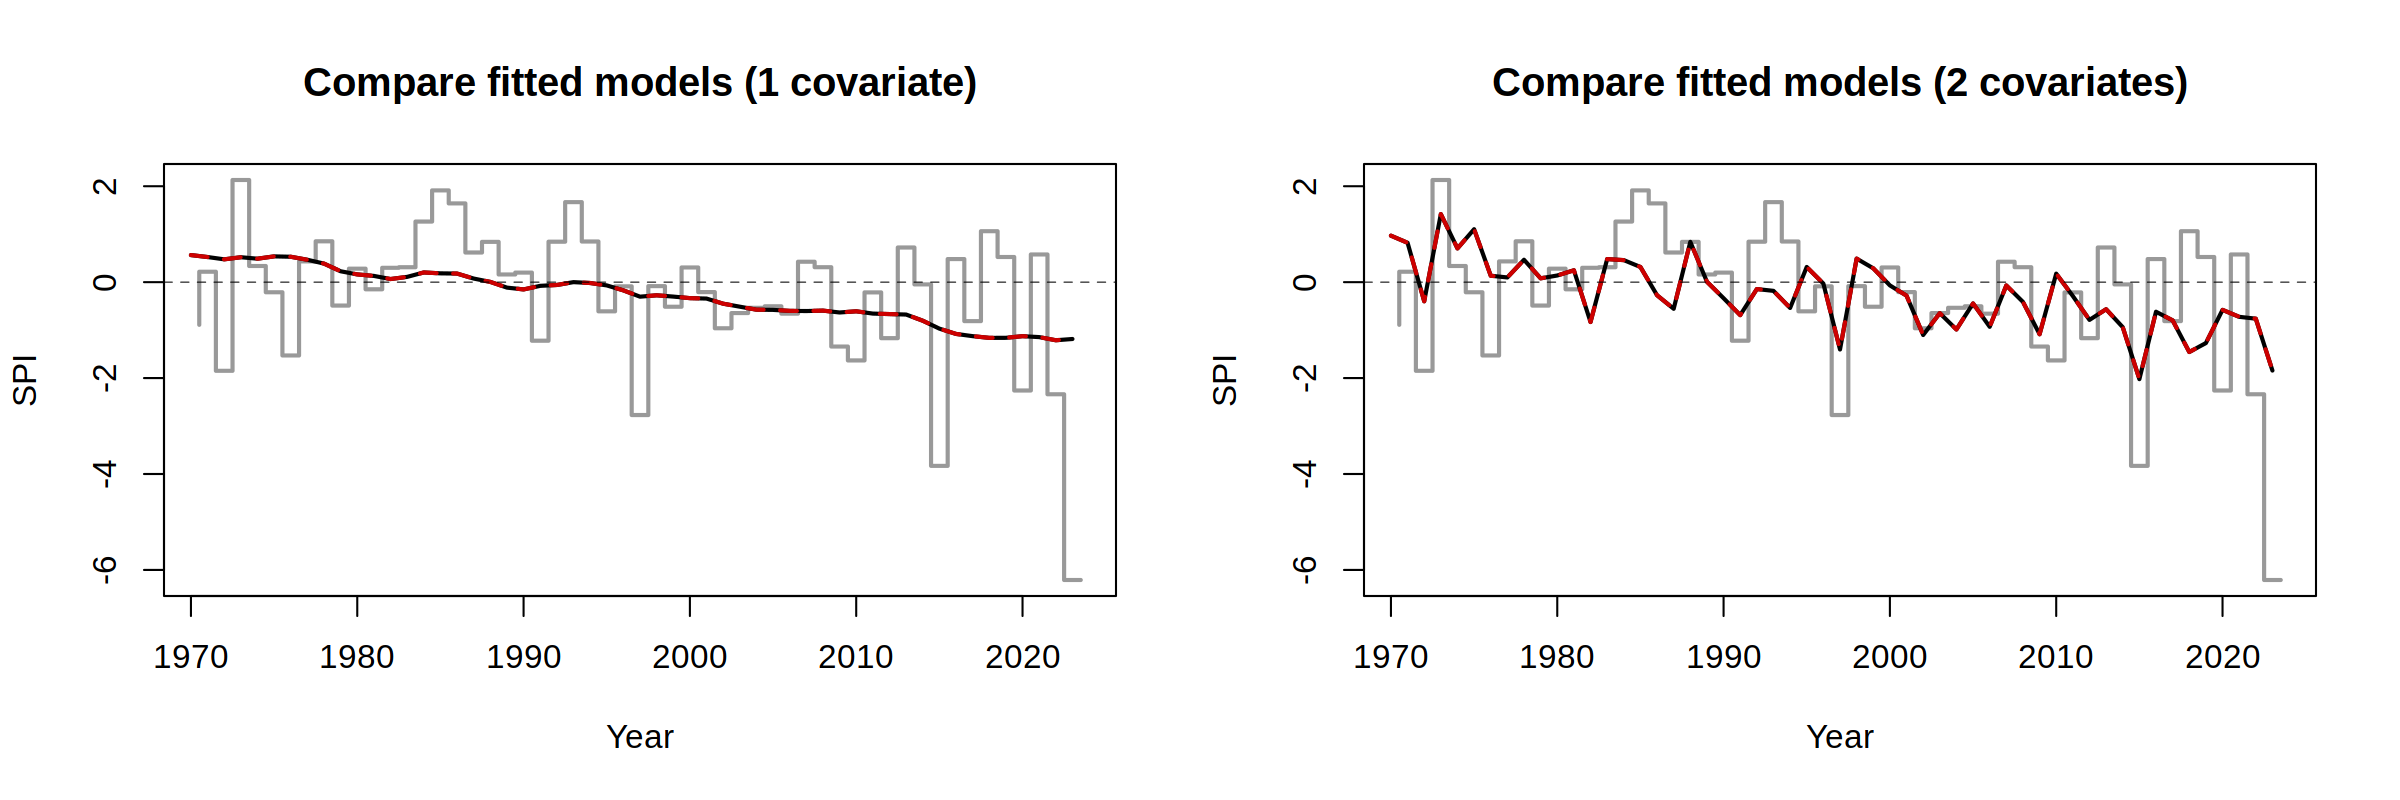

In [ ]:
prep_window(c(1,3)); par(mfrow = c(1,2))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$year+0.5, df$spi, type = "S", lwd = 2, col = adjustcolor("black", 0.4), xlab = "Year", ylab = "SPI", main = "Compare fitted models (1 covariate)")

lines(df$year, ns_pars(mdl1_ns)$loc, lwd = 2)
lines(df$year, predict(mdl1_lm, newdata = data.frame(gmst = df$gmst, nino = 0)), lwd = 2, lty = 2, col = "red3")
abline(h = 0, lty = 2, lwd = 0.5)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$year+0.5, df$spi, type = "S", lwd = 2, col = adjustcolor("black", 0.4), xlab = "Year", ylab = "SPI", main = "Compare fitted models (2 covariates)")

lines(df$year, ns_pars(mdl2_ns)$loc, lwd = 2)
lines(df$year, predict(mdl2_lm), lwd = 2, lty = 2, col = "red3")
abline(h = 0, lty = 2, lwd = 0.5)

### **Test that all sub-functions work ok**

In [30]:
ns_pars(mdl1_ns)

$loc
 [1]  0.5644930536  0.5234351138  0.4756586171  0.5193293250  0.4890957596
 [6]  0.5372455116  0.5294071712  0.4667005041  0.3864509146  0.2266982136
[11]  0.1613788302  0.1300254976  0.0647059350  0.1098697837  0.2020634522
[16]  0.1834006944  0.1789216469  0.0747837920  0.0049853611 -0.1140825925
[21] -0.1517813022 -0.0771304504 -0.0588410661  0.0001329402 -0.0177830707
[26] -0.0677991612 -0.1715638218 -0.3029491562 -0.2742085415 -0.3010828266
[31] -0.3335559212 -0.3425140162 -0.4492647683 -0.5115980603 -0.5739315314
[36] -0.5784105789 -0.5989396662 -0.6026721460 -0.5937140510 -0.6325325226
[41] -0.6078977612 -0.6556741487 -0.6657520056 -0.6754566683 -0.8042292846
[46] -0.9692074754 -1.0796907074 -1.1259741387 -1.1618065189 -1.1606867570
[51] -1.1267207064 -1.1457566583 -1.2115737534 -1.1853215184

$scale
 [1] 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645
 [9] 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645
[17] 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645
[25] 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645
[33] 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645
[41] 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645
[49] 1.304645 1.304645 1.304645 1.304645 1.304645 1.304645